
#  Teoría

---

## 1. Sesgo-varianza en clasificación de texto

El sesgo se da cuando el modelo es demasiado simple y no captura la complejidad del lenguaje (subajuste).  
La varianza ocurre cuando el modelo se ajusta demasiado a los datos de entrenamiento, perdiendo capacidad de generalización (sobreajuste).  
En NLP, modelos con muy pocas features (ejemplo: BoW con límite bajo de vocabulario) tienen alto sesgo; en cambio, modelos muy complejos sin regularización suelen tener alta varianza.

---

## 2. F1 vs. ROC-AUC: ¿cuándo usar cada uno?

- **F1**: se usa cuando hay **desbalance de clases** y queremos medir el balance entre precisión y recall.  
- **ROC-AUC**: mide la capacidad del modelo para distinguir entre clases en distintos umbrales. Es útil cuando tenemos clases más balanceadas o queremos evaluar ranking de probabilidades.

---

## 3. Estrategias para *class imbalance*

1. **Recolección de más datos** de la clase minoritaria.  
2. **Re-muestreo**: oversampling (ej. SMOTE) o undersampling.  
3. **Uso de métricas robustas** (F1 macro, ROC-AUC).  
4. **Ponderación de clases** en el entrenamiento (ej. `class_weight='balanced'` en `LogisticRegression`).

---

## 4. Beneficios de regularización L2

- Reduce el riesgo de sobreajuste penalizando coeficientes muy grandes.  
- Favorece soluciones más estables y generalizables.  
- En clasificación de texto (donde el número de features es alto), L2 ayuda a controlar el peso de palabras poco informativas.

---

## 5. Métricas de *fairness* en este modelo

Se pueden evaluar métricas como:  
- **Equal Opportunity**: la tasa de verdaderos positivos debería ser similar entre grupos.  
- **Demographic Parity**: las predicciones positivas deberían estar distribuidas de forma balanceada entre grupos sensibles (género, región, etc.).  
- **Disparate Impact**: proporción de resultados positivos entre grupos no debe diferir demasiado.

---

#  Métricas reportadas
- **F1 macro**: evalúa rendimiento balanceado entre clases.  
- **ROC-AUC**: mide discriminación entre clases.  
- **Matriz de confusión**: muestra aciertos y errores de clasificación.


In [14]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Fijar semilla para reproducibilidad
random.seed(42)
np.random.seed(42)

# Listas de palabras para generar oraciones
temas_nlp = ['tokenización', 'embeddings', 'modelos de lenguaje', 'LLMs', 'transformers', 'clasificación', 'regularización', 'perplejidad', 'BPE', 'lematización']
adjetivos_positivos = ['fascinante', 'útil', 'innovador', 'impresionante', 'eficiente', 'claro', 'esencial']
adjetivos_negativos = ['complicado', 'confuso', 'difícil', 'lento', 'limitado', 'frustrante']
adjetivos_neutrales = ['interesante', 'técnico', 'complejo', 'fundamental', 'necesario']
verbos = ['es', 'parece', 'resulta', 'se usa para', 'ayuda a', 'requiere', 'mejora']

# Plantillas para oraciones
plantillas = [
    "La {tema} {verbo} {adjetivo} para procesar texto.",
    "Entender los {tema} {verbo} {adjetivo} en el curso de NLP.",
    "Los {tema} son {adjetivo} pero {adjetivo_complementario}.",
    "Implementar {tema} {verbo} {adjetivo} en proyectos reales.",
    "No entiendo cómo funciona la {tema}, es {adjetivo}.",
]

# Generar oraciones
def generar_oracion(categoria):
    plantilla = random.choice(plantillas)
    tema = random.choice(temas_nlp)
    verbo = random.choice(verbos)
    if categoria == 'Positivo':
        adjetivo = random.choice(adjetivos_positivos)
        adjetivo_complementario = random.choice(adjetivos_positivos + adjetivos_neutrales)
    elif categoria == 'Negativo':
        adjetivo = random.choice(adjetivos_negativos)
        adjetivo_complementario = random.choice(adjetivos_negativos + adjetivos_neutrales)
    else:  # Neutral
        adjetivo = random.choice(adjetivos_neutrales)
        adjetivo_complementario = random.choice(adjetivos_neutrales + adjetivos_positivos)
    return plantilla.format(tema=tema, verbo=verbo, adjetivo=adjetivo, adjetivo_complementario=adjetivo_complementario)

# Generar dataset
n_oraciones = 8000
categorias = ['Positivo', 'Negativo', 'Neutral']
proporciones = [0.4, 0.3, 0.3]  # Distribución aproximada
oraciones = []
labels = np.random.choice(categorias, size=n_oraciones, p=proporciones)

for label in labels:
    oraciones.append(generar_oracion(label))

# Crear DataFrame
df = pd.DataFrame({'Texto': oraciones, 'Categoría': labels})

# Añadir ejemplos reales (inspirados en el dataset original)
ejemplos_reales = [
    ("La tokenización es clave para procesar texto", "Positivo"),
    ("No entiendo los embeddings vectoriales", "Negativo"),
    ("Los LLMs son impresionantes pero complejos", "Neutral"),
    ("El curso de NLP es fascinante y útil", "Positivo"),
    ("La programación en Python es complicada al principio", "Negativo"),
]
df = pd.concat([pd.DataFrame(ejemplos_reales, columns=['Texto', 'Categoría']), df]).reset_index(drop=True)

# Guardar dataset
df.to_csv('nlp_prueba_cc0c2_large.csv', index=False)
print(f"Dataset generado: {len(df)} oraciones en 'nlp_prueba_cc0c2_large.csv'")

Dataset generado: 8005 oraciones en 'nlp_prueba_cc0c2_large.csv'


Dimensiones del dataset: (8005, 2)

Primeras 5 filas:
                                               Texto    sentiment
0       La tokenización es clave para procesar texto     Positivo
1             No entiendo los embeddings vectoriales  No Positivo
2         Los LLMs son impresionantes pero complejos  No Positivo
3               El curso de NLP es fascinante y útil     Positivo
4  La programación en Python es complicada al pri...  No Positivo

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8005 entries, 0 to 8004
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Texto      8005 non-null   object
 1   sentiment  8005 non-null   object
dtypes: object(2)
memory usage: 125.2+ KB
None

Distribución de clases:
sentiment
No Positivo    4753
Positivo       3252
Name: count, dtype: int64

Proporción de clases:
sentiment
No Positivo    0.593754
Positivo       0.406246
Name: proportion, dtype: float64


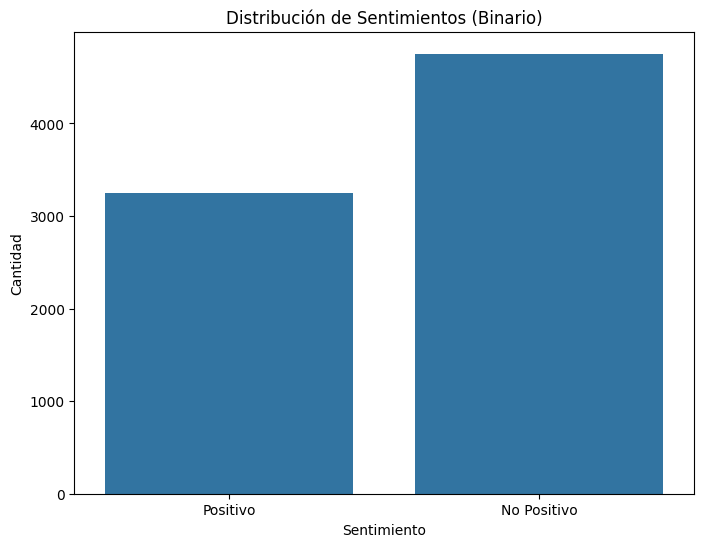

In [3]:
# =====================
# EXPLORACIÓN DE DATOS
# =====================
df = pd.read_csv('/content/nlp_prueba_cc0c2_large.csv')

# Renombrar la columna 'Categoría' a 'sentiment' para coincidir con el código posterior
df = df.rename(columns={'Categoría': 'sentiment'})

# Convertir a clasificación binaria: Positivo vs. No Positivo
df['sentiment'] = df['sentiment'].apply(lambda x: 'Positivo' if x == 'Positivo' else 'No Positivo')

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())
print("\nInformación del dataset:")
print(df.info())
print("\nDistribución de clases:")
print(df['sentiment'].value_counts())
print("\nProporción de clases:")
print(df['sentiment'].value_counts(normalize=True))

# Visualización de la distribución de clases
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribución de Sentimientos (Binario)')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()

#Regresión logística (scikit-learn) con BoW/TF-IDF para clasificar 8,000 oraciones

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


##Dividir dataset en train/test (80% entrenamiento, 20% prueba)

In [5]:
X = df["Texto"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#Representaciones de texto (BoW) / TF-IDF

#1. Bag of Words (BoW)

In [6]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


#2. TF-IDF

In [7]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


#Comparamos L2 vs sin regularizacion.

#regularización L2 (Ridge)

In [8]:
# log_reg_l2 = LogisticRegression(max_iter=1000, penalty="l2", solver="liblinear")
log_reg_l2_bow = LogisticRegression(max_iter=1000, penalty="l2", solver="lbfgs")
log_reg_l2_bow.fit(X_train_bow, y_train)


LogisticRegression(max_iter=1000)

In [9]:
# log_reg_l2 = LogisticRegression(max_iter=1000, penalty="l2", solver="liblinear")
log_reg_l2_tfidf = LogisticRegression(max_iter=1000, penalty="l2", solver="lbfgs")
log_reg_l2_tfidf.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

#Sin regularización

In [10]:
log_reg_none_bow = LogisticRegression(max_iter=1000, penalty=None, solver="lbfgs")
log_reg_none_bow.fit(X_train_bow, y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [11]:
log_reg_none_tfidf = LogisticRegression(max_iter=1000, penalty=None, solver="lbfgs")
log_reg_none_tfidf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, penalty=None)

#Evaluamos los Modelos

=== Logistic Regression con L2 (BoW) ===
              precision    recall  f1-score   support

 No Positivo       0.95      0.98      0.97       951
    Positivo       0.97      0.93      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.95      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9971293375394322


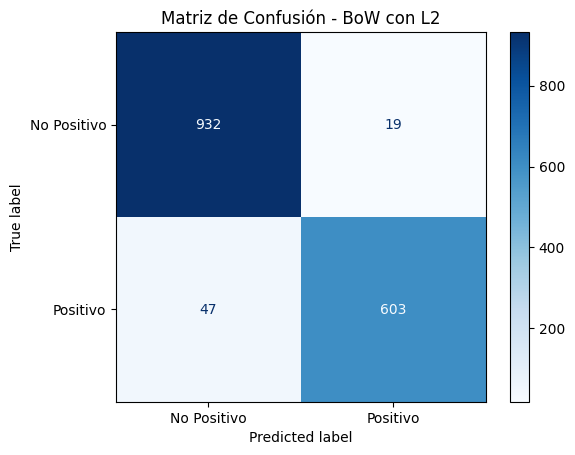

In [15]:
# Convertir labels a binarios
y_test_bin = y_test.map({"No Positivo":0, "Positivo":1})

# -------------------
# 1. BoW con L2
# -------------------
y_pred_l2_bow = log_reg_l2_bow.predict(X_test_bow)
print("=== Logistic Regression con L2 (BoW) ===")
print(classification_report(y_test, y_pred_l2_bow))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_l2_bow.predict_proba(X_test_bow)[:,1]))

cm_bow_l2 = confusion_matrix(y_test, y_pred_l2_bow)
ConfusionMatrixDisplay(cm_bow_l2, display_labels=["No Positivo","Positivo"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - BoW con L2")
plt.show()



=== Logistic Regression sin regularización (BoW) ===
              precision    recall  f1-score   support

 No Positivo       0.96      0.98      0.97       951
    Positivo       0.97      0.94      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9971180134271617


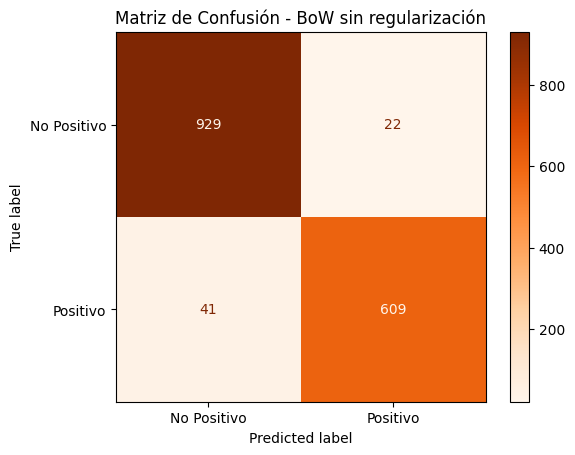

In [16]:

# -------------------
# 2. BoW sin regularización
# -------------------
y_pred_none_bow = log_reg_none_bow.predict(X_test_bow)
print("\n=== Logistic Regression sin regularización (BoW) ===")
print(classification_report(y_test, y_pred_none_bow))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_none_bow.predict_proba(X_test_bow)[:,1]))

cm_bow_none = confusion_matrix(y_test, y_pred_none_bow)
ConfusionMatrixDisplay(cm_bow_none, display_labels=["No Positivo","Positivo"]).plot(cmap="Oranges")
plt.title("Matriz de Confusión - BoW sin regularización")
plt.show()



=== Logistic Regression con L2 (TF-IDF) ===
              precision    recall  f1-score   support

 No Positivo       0.95      0.99      0.97       951
    Positivo       0.98      0.92      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9972361077408396


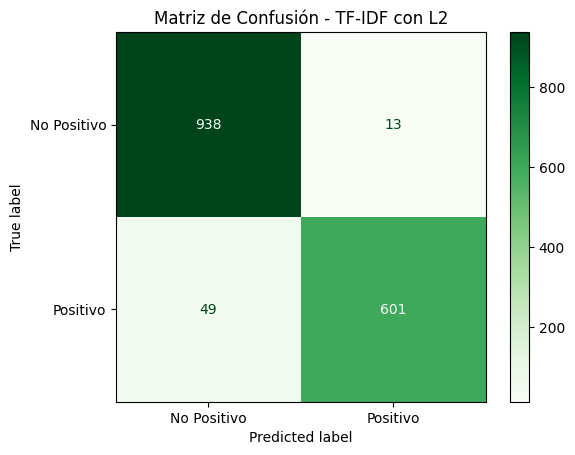

In [18]:

# -------------------
# 3. TF-IDF con L2
# -------------------
y_pred_l2_tfidf = log_reg_l2_tfidf.predict(X_test_tfidf)
print("\n=== Logistic Regression con L2 (TF-IDF) ===")
print(classification_report(y_test, y_pred_l2_tfidf))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_l2_tfidf.predict_proba(X_test_tfidf)[:,1]))

cm_tfidf_l2 = confusion_matrix(y_test, y_pred_l2_tfidf)
ConfusionMatrixDisplay(cm_tfidf_l2, display_labels=["No Positivo","Positivo"]).plot(cmap="Greens")
plt.title("Matriz de Confusión - TF-IDF con L2")
plt.show()



=== Logistic Regression sin regularización (TF-IDF) ===
              precision    recall  f1-score   support

 No Positivo       0.96      0.98      0.97       951
    Positivo       0.96      0.94      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9970937474722964


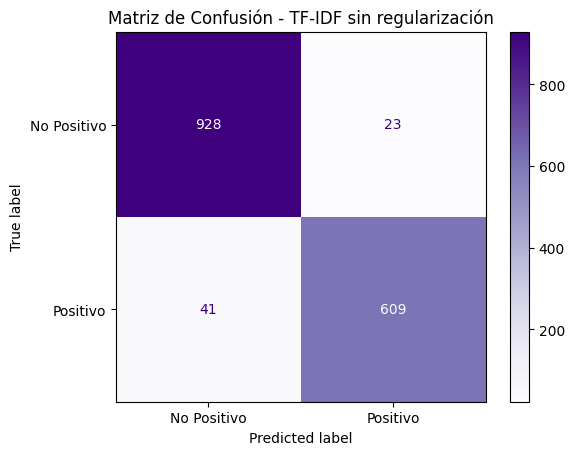

In [19]:

# -------------------
# 4. TF-IDF sin regularización
# -------------------
y_pred_none_tfidf = log_reg_none_tfidf.predict(X_test_tfidf)
print("\n=== Logistic Regression sin regularización (TF-IDF) ===")
print(classification_report(y_test, y_pred_none_tfidf))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_none_tfidf.predict_proba(X_test_tfidf)[:,1]))

cm_tfidf_none = confusion_matrix(y_test, y_pred_none_tfidf)
ConfusionMatrixDisplay(cm_tfidf_none, display_labels=["No Positivo","Positivo"]).plot(cmap="Purples")
plt.title("Matriz de Confusión - TF-IDF sin regularización")
plt.show()


=== Logistic Regression con L2 (BoW) ===
              precision    recall  f1-score   support

 No Positivo       0.95      0.98      0.97       951
    Positivo       0.97      0.93      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.95      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9971293375394322


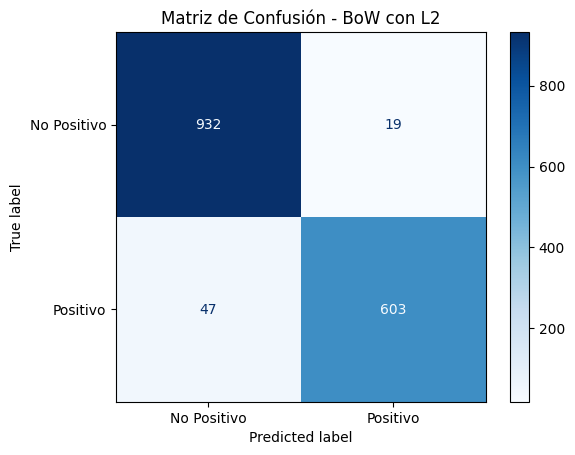


=== Logistic Regression sin regularización (BoW) ===
              precision    recall  f1-score   support

 No Positivo       0.96      0.98      0.97       951
    Positivo       0.97      0.94      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9971180134271617


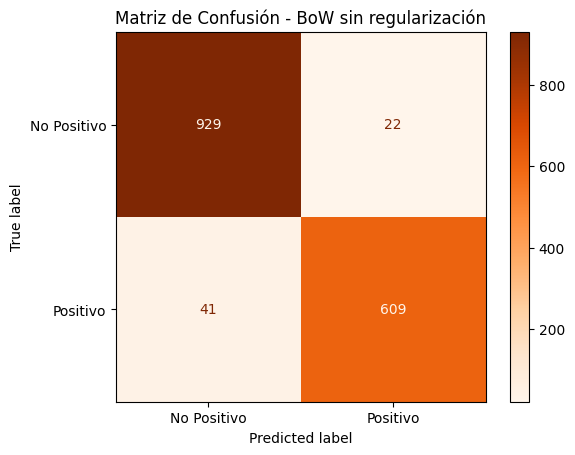


=== Logistic Regression con L2 (TF-IDF) ===
              precision    recall  f1-score   support

 No Positivo       0.95      0.99      0.97       951
    Positivo       0.98      0.92      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9972361077408396


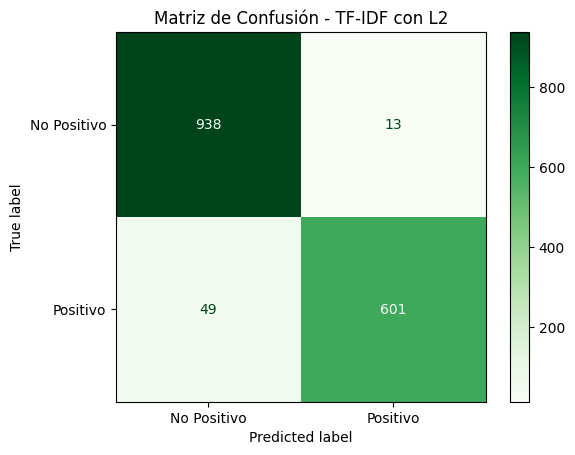


=== Logistic Regression sin regularización (TF-IDF) ===
              precision    recall  f1-score   support

 No Positivo       0.96      0.98      0.97       951
    Positivo       0.96      0.94      0.95       650

    accuracy                           0.96      1601
   macro avg       0.96      0.96      0.96      1601
weighted avg       0.96      0.96      0.96      1601

ROC-AUC: 0.9970937474722964


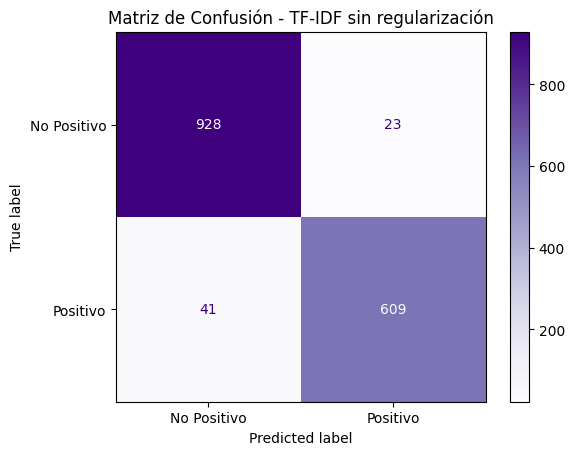

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convertir labels a binarios
y_test_bin = y_test.map({"No Positivo":0, "Positivo":1})

# -------------------
# 1. BoW con L2
# -------------------
y_pred_l2_bow = log_reg_l2_bow.predict(X_test_bow)
print("=== Logistic Regression con L2 (BoW) ===")
print(classification_report(y_test, y_pred_l2_bow))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_l2_bow.predict_proba(X_test_bow)[:,1]))

cm_bow_l2 = confusion_matrix(y_test, y_pred_l2_bow)
ConfusionMatrixDisplay(cm_bow_l2, display_labels=["No Positivo","Positivo"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - BoW con L2")
plt.show()

# -------------------
# 2. BoW sin regularización
# -------------------
y_pred_none_bow = log_reg_none_bow.predict(X_test_bow)
print("\n=== Logistic Regression sin regularización (BoW) ===")
print(classification_report(y_test, y_pred_none_bow))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_none_bow.predict_proba(X_test_bow)[:,1]))

cm_bow_none = confusion_matrix(y_test, y_pred_none_bow)
ConfusionMatrixDisplay(cm_bow_none, display_labels=["No Positivo","Positivo"]).plot(cmap="Oranges")
plt.title("Matriz de Confusión - BoW sin regularización")
plt.show()

# -------------------
# 3. TF-IDF con L2
# -------------------
y_pred_l2_tfidf = log_reg_l2_tfidf.predict(X_test_tfidf)
print("\n=== Logistic Regression con L2 (TF-IDF) ===")
print(classification_report(y_test, y_pred_l2_tfidf))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_l2_tfidf.predict_proba(X_test_tfidf)[:,1]))

cm_tfidf_l2 = confusion_matrix(y_test, y_pred_l2_tfidf)
ConfusionMatrixDisplay(cm_tfidf_l2, display_labels=["No Positivo","Positivo"]).plot(cmap="Greens")
plt.title("Matriz de Confusión - TF-IDF con L2")
plt.show()

# -------------------
# 4. TF-IDF sin regularización
# -------------------
y_pred_none_tfidf = log_reg_none_tfidf.predict(X_test_tfidf)
print("\n=== Logistic Regression sin regularización (TF-IDF) ===")
print(classification_report(y_test, y_pred_none_tfidf))
print("ROC-AUC:", roc_auc_score(y_test_bin, log_reg_none_tfidf.predict_proba(X_test_tfidf)[:,1]))

cm_tfidf_none = confusion_matrix(y_test, y_pred_none_tfidf)
ConfusionMatrixDisplay(cm_tfidf_none, display_labels=["No Positivo","Positivo"]).plot(cmap="Purples")
plt.title("Matriz de Confusión - TF-IDF sin regularización")
plt.show()
